# Notebook to tune Echo State network

### Summary from the paper 'A practical guide to applying echo state networks'
This section gives a summary of the 'general wisdoms' presented in the paper on how to handle an ESN. 

### Parameters 

##### Reservoir size
A bigger reservoir results in better approximation of a signal GIVEN appropriate regularization. Thus for highly complex signals that need to be modeled, use as big a reservoir as you can afford computationally. However, starting with a very large reservoir can be cumbersome. Therefore, select global parameters with a smaller reservoir size, then scale to a bigger one. Good parameters are usually transferable to bigger reservoirs (but some trials with big reservoirs can also be done to confirm this). A lower bound for the reservoir size N x can roughly be estimated by considering the number of independent real values that the reservoir must remember from the input to successfully accomplish the task.

##### Sparsity 
In the origional ESN publication it is recommended to make the reservoir connections sparse. That is, make most of the elements in W_in (CHECK THIS? WHY W_in?) equal to zero. This results in slightly better performance and enables fast reservoir updates. However, sparsity of the reservoir does not affect hte performanc much ans this paramater has a low priority to be optimized. It is therefore ignored in this paper.

##### Spectral radius
The spectral radius (rho) is the maximum absolute eigenvalue of the matrix W. It scales the width of the distrbiution of its nonzero elements. For the ESN approach to work, the reservoirs should satisfy the echo state property. That is, for a long enough input u(n), the reseroir state x(n) should not depend on the initial state of x(n). 
Large rho can lead to chaotic reservoirs that violate the echo state property. rho smaller than 1 ensures the echo state property in most cases. As a guiding principle, rho should be set large for tasks where a more exntensive history of the input is required, and small for tasks where the output y(n) depends more heavily on the current input u(n). i.e. rho should be great in tasks requiring longer memory of the input.

##### Input and bias scaling
It works best to scale the input and bias seperatly. Adtionally, it is even better to scale the columns of W_in seperately aswell. However, for simplicity, we scale the matrix W_in with a single value.
Input sclaing determines how nonlinear the reservoir rsponses are. For very linear tasks, W_in should be small. This results in the internal neurons operate around the 0 point where their activation is virtually linear (tanh). For large W_in, the units will get saturared and squished to their max activation 1, -1. Like a binary switching manner. Rho also affects non-linearity, but it can only be scaled so much untill the reservoir becomes unstable.
The amount of non linearity a task requires is not easy to judge. Finding a good tuning value is easier with experience. This parameter will have to be scaled by trial and error. 
The scaling of W_in together with spectral radius Rho determines the proportion of how much the current state x(n) depends on the current input u(n).

##### Leaking rate
The leaking rate alpha can be regarded as the speed of the reservoir update dynamics discretized in time. This leaking rate can be adapted such that different internal units have different leaking rates (so alpha is a vector), but for simplicity we stick to a single scalar. 
Alpha should be set to mathc the speed of the dynamcis of u(n) and/or y_target(n).This can, again, be difficult and subjective to determine in some cases Especially when the timescales of u(n) and y target (n) are quite different. This is one more of the global parameters to be tuned by trial and error.

### Tuning

The three main parameters to optimize are:
- Input scaling / bias scaling
- Spectral radius
- Leaking rate

The reservoir size almost comes as an external paramater, and the rest of the design choices (sampling distribution of weights, sparsity) have a lower priority. They will therefore not be tuned for simplicity. 

It is important to note that randomly generated reservoirs with identical parameters can yield different performance. This variation tends to be higher with smaller reservoirs. To elimante this effect, either average performance over several reservoir samples, or set a seed for the weight sampling. It should be noted that a seed gives a risk over paramater overfitting to a particular randomly generated W matrix. 

When tuning parameters by hand, change one parameter at the time. Once a good paramater is established, move to the next one. A nice bonus is that PAPER notes that Typically, good average performance is not found in a very narrow parameter range, thus a very
detailed fine-tuning of parameters does not give a significant improvement and is not necessary.

Aditionally it is very helpful to plot the reservoir activation signals x(n) to have a 'feel' of what is happening inside the reservoir. 

When having computed the readout weights, inspect the weights. Large values in W_out might be an indication of very sensitive and unstable solution. 

Select regularization param B for a concerte ESN using validation, without rerunning the reservoir through the training data. 

Get rid of 'washout time' aka initial transient. The initial transient is in essence a result of an arbitrary setting of x(0), which is typically
x(0) = 0. This introduces an unnatural starting state which is not normally visited once the network
has “warmed up” to the task. The amount of time steps to discard depends on the memory of the
network (which in turn depends on reservoir parameters), and typically are in the order of tens or hundreds.








## Tuning parameters

In [16]:
import numpy as np
from esn import ESN
from data_io.model_data import convert_raw_to_training_data, load_data_raw

K = 5
RESERVOIR = 100
W_IN = 1
BIAS = 1
SP = 1
LEAKING = 1
RIDGE_PARAM = 0



In [2]:
midi_raw = load_data_raw('F.txt')[:-16, :]
data, ove, ive = convert_raw_to_training_data(
    midi_raw, window_length=1, flatten_output=True)

u, y = data

In [3]:
def run_k_times(k, model):
    avg_acc = 0
    for _ in range(k):
        acc, mse = model.fit(u, y)
        avg_acc += acc
    return avg_acc / k

#### Input scaling

In [22]:
W_in_scaling = np.arange(0.025, 1, 0.025)
high_score = 0
best_param = None
for s in W_in_scaling:
    esn = ESN(u.shape[1], y.shape[1], reservoir_size=RESERVOIR, W_in_scaling=s, 
        bias_scaling=BIAS, spectral_radius=SP, leaking_rate=LEAKING, ridge_param=RIDGE_PARAM, ive=ive, ove=ove)
    acc = run_k_times(K, esn)
    print(f'Scaling: {s:.2f} Average training acc: {acc:.3f}')
    if acc > high_score:
        high_score = acc
        best_param = s

print(f'Param: {best_param:.1f} With highest training acc: {high_score:.3f}')


Scaling: 0.03 Average training acc: 0.816
Scaling: 0.05 Average training acc: 0.816
Scaling: 0.08 Average training acc: 0.816
Scaling: 0.10 Average training acc: 0.816
Scaling: 0.12 Average training acc: 0.814
Scaling: 0.15 Average training acc: 0.816
Scaling: 0.18 Average training acc: 0.816
Scaling: 0.20 Average training acc: 0.818
Scaling: 0.23 Average training acc: 0.817
Scaling: 0.25 Average training acc: 0.817
Scaling: 0.28 Average training acc: 0.816
Scaling: 0.30 Average training acc: 0.815
Scaling: 0.33 Average training acc: 0.816
Scaling: 0.35 Average training acc: 0.815
Scaling: 0.38 Average training acc: 0.817
Scaling: 0.40 Average training acc: 0.815
Scaling: 0.43 Average training acc: 0.814
Scaling: 0.45 Average training acc: 0.817
Scaling: 0.48 Average training acc: 0.815
Scaling: 0.50 Average training acc: 0.814
Scaling: 0.53 Average training acc: 0.815
Scaling: 0.55 Average training acc: 0.814
Scaling: 0.58 Average training acc: 0.814
Scaling: 0.60 Average training acc

In [23]:
W_IN = 0.2

### Bias scaling

In [25]:
bias_scaling = np.arange(0.1, 2.1, 0.1)
high_score = 0
best_param = None
for s in bias_scaling:
    esn = ESN(u.shape[1], y.shape[1], reservoir_size=RESERVOIR, W_in_scaling=W_IN, 
        bias_scaling=s, spectral_radius=SP, leaking_rate=LEAKING, ridge_param=RIDGE_PARAM, ive=ive, ove=ove)
    acc = run_k_times(K, esn)
    print(f'Scaling: {s:.3f} Average training acc: {acc:.3f}')
    if acc > high_score:
        high_score = acc
        best_param = s

print(f'Param: {best_param:.3f} With highest training acc: {high_score:.3f}')

Scaling: 0.100 Average training acc: 0.816
Scaling: 0.200 Average training acc: 0.817
Scaling: 0.300 Average training acc: 0.819
Scaling: 0.400 Average training acc: 0.817
Scaling: 0.500 Average training acc: 0.816
Scaling: 0.600 Average training acc: 0.815
Scaling: 0.700 Average training acc: 0.816
Scaling: 0.800 Average training acc: 0.816
Scaling: 0.900 Average training acc: 0.816
Scaling: 1.000 Average training acc: 0.814
Scaling: 1.100 Average training acc: 0.817
Scaling: 1.200 Average training acc: 0.815
Scaling: 1.300 Average training acc: 0.816
Scaling: 1.400 Average training acc: 0.815
Scaling: 1.500 Average training acc: 0.815
Scaling: 1.600 Average training acc: 0.816
Scaling: 1.700 Average training acc: 0.815
Scaling: 1.800 Average training acc: 0.817
Scaling: 1.900 Average training acc: 0.815
Scaling: 2.000 Average training acc: 0.815
Param: 0.300 With highest training acc: 0.819


In [26]:
BIAS = 0.3

### Spectral radius

In [29]:
spectral_radius = np.arange(0.1, 1.2, 0.1)
high_score = 0
best_param = None
for s in spectral_radius:
    esn = ESN(u.shape[1], y.shape[1], reservoir_size=RESERVOIR, W_in_scaling=W_IN, 
        bias_scaling=BIAS, spectral_radius=s, leaking_rate=LEAKING, ridge_param=RIDGE_PARAM, ive=ive, ove=ove)
    acc = run_k_times(K, esn)
    print(f'Scaling: {s:.3f} Average training acc: {acc:.3f}')
    if acc > high_score:
        high_score = acc
        best_param = s

print(f'Param: {best_param:.3f} With highest training acc: {high_score:.3f}')

Scaling: 0.100 Average training acc: 0.825
Scaling: 0.200 Average training acc: 0.825
Scaling: 0.300 Average training acc: 0.824
Scaling: 0.400 Average training acc: 0.824
Scaling: 0.500 Average training acc: 0.824
Scaling: 0.600 Average training acc: 0.824
Scaling: 0.700 Average training acc: 0.822
Scaling: 0.800 Average training acc: 0.821
Scaling: 0.900 Average training acc: 0.821
Scaling: 1.000 Average training acc: 0.819
Scaling: 1.100 Average training acc: 0.813
Param: 0.200 With highest training acc: 0.825


In [30]:
SP = 0.2

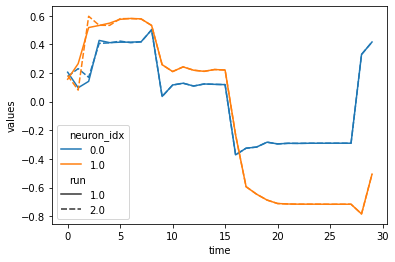

In [33]:
esn = ESN(u.shape[1], y.shape[1], reservoir_size=RESERVOIR, W_in_scaling=W_IN, 
        bias_scaling=BIAS, spectral_radius=0.6, leaking_rate=LEAKING, ridge_param=RIDGE_PARAM, ive=ive, ove=ove)
esn.fit(u, y)
esn.determine_washout_time(u, y, 2, 30)